In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/Fishchecker Colab'

/content/drive/MyDrive/Fishchecker Colab


In [3]:
from python.util.video2img import video2img
from python.util.rotationimg import *
from python.util.cal import *
from google.colab.patches import cv2_imshow

from PIL import Image
import pandas as pd
import numpy as np
import cv2
import re
import time


In [4]:
st = time.time()
filename = 'test'
video2img(file=filename)
%cd ./python/classifiers/yolov7
!python detect.py --weights v16_best.pt --img 640 --source 'testdata/images/test'

# Frame choice(가장 넓은 면적)
f = open('xyxy.txt')
lines = f.readlines()
_lines = []
for l in lines[::-1]:
  #print(l.split('/'))
  if re.match('frame', l.split('/')[0]):
    _lines.append(l.split('/'))
f.close()
_lines.sort(key=lambda x:int(x[2]), reverse=True)
bestframe = _lines[0][0]
bestframepath = 'testdata/images/'+filename+'/%s'%bestframe

species = list(np.array(_lines).T[1])
species = max(species, key=species.count)


# Choice한 frame rotation
best_img = Image.open(bestframepath)
[best_img.rotate(i).save('./rotatedimg/rotate'+str(i)+'.jpg') for i in range(0,91,5)]
[best_img.rotate(i).save('./rotatedimg/rotate'+str(i)+'.jpg') for i in range(-1,-91,-5)]

!python detect.py --weights v16_best.pt --img 640 --source './rotatedimg/'

f = open('xyxy.txt')
lines = f.readlines()
_lines = []
for l in lines[::-1]:
  #print(l.split('/'))
  if re.match('rotate', l.split('/')[0]):
    _lines.append(l.split('/'))
f.close()
_lines.sort(key=lambda x:int(x[4]), reverse = False)
rotatedbestframe = _lines[0]
rotatedbestframepath = 'rotatedimg/%s'%rotatedbestframe[0]
fishIL = int(rotatedbestframe[3])

bgrLower = np.array([10, 0, 10])    # 추출할 색의 하한(BGR)
bgrUpper = np.array([255, 136, 100])    # 추출할 색의 상한(BGR)
for _ in _lines:
  _img = cv2.imread('./rotatedimg/'+_[0], cv2.IMREAD_UNCHANGED)
  #cv2_imshow(_img)
  img_mask = cv2.inRange(_img, bgrLower, bgrUpper) # BGR로 부터 마스크를 작성
  result = cv2.bitwise_and(_img, _img, mask=img_mask) # 원본 이미지와 마스크를 합성
  #_img.save('/bongimg/bongimg_'+_[0])
  cv2.imwrite('./bongimg/bongimg'+_[0], result)

!python detect.py --weights bong_v5_best.pt --img 640 --source './bongimg/'

f = open('xyxy.txt')
lines = f.readlines()
_lines = []
for l in lines[::-1]:
  #print(l.split('/'))
  if re.match('bongimg', l.split('/')[0]):
    _lines.append(l.split('/'))
f.close()
f = open("xyxy.txt", 'w')
f.close()
_lines.sort(key=lambda x:int(x[4]), reverse = False)

bongbestframe = _lines[0][0]
bongIT = int(_lines[0][4])



fishTL = cal_fishTL(fishIL, bongIT)
weight = cal_weight(species, fishTL)

pd.set_option('display.max_colwidth', -1)
info = pd.DataFrame(speciesinfo[species]).T
info.columns = ["Species", "분포", "구별법", "추천음식"]
info.insert(1, "Relative fish length in image (Fish IL)", [str(round(fishIL, 3))])
info.insert(2, "Relative scoop net handle thickness in image (Bong IT)", [str(round(bongIT, 3))])
info.insert(3, "Length (Fish TL)", [str(round(fishTL, 3)) + 'cm'])
info.insert(4, "Weight (Fish WW)", [str(round(weight, 3)) + 'g'])
info = info.rename(index = {0:species})
print(time.time()-st,"s\n\n")
info

/content/drive/MyDrive/Fishchecker Colab/python/util /content/drive/MyDrive/Fishchecker Colab/python
./python/classifiers/yolov7/testdata/test.mp4
Video2Img complete
/content/drive/MyDrive/Fishchecker Colab/python/classifiers/yolov7
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='testdata/images/test', update=False, view_img=False, weights=['v16_best.pt'])
YOLOR 🚀 2022-8-25 torch 1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
IAuxDetect.fuse
Model Summary: 370 layers, 80995916 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **k

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Species,Relative fish length in image (Fish IL),Relative scoop net handle thickness in image (Bong IT),Length (Fish TL),Weight (Fish WW),분포,구별법,추천음식
G,고등어 : Scomber Japonicus,704,59,25.058cm,124.346g,"태평양 (한국 남부, 일본에서 마이크로네시아, 호주 북부), 인도양","몸 등쪽은 짙은 청색을 띠며 중앙에서부터 밝아져 배쪽은 은백색을 띤다.주새개골의 끝에는 검은색 얼룩 점이 있다. 모든 지느러미는 희거나 무색투명하며, 꼬리지느러미만 어두운 갈색을 띤다.",1. 고등어 조림 2. 고갈비 3. 고등어 강정 4. 고등어 샌드위치 5. 고등어 찌개 6. 깐풍 고등어 7. 고등어 된장구이 초밥


Best frame: frame150.jpg Rotated best frame: rotate15.jpg Bong best frame: bongimgrotate40.jpg


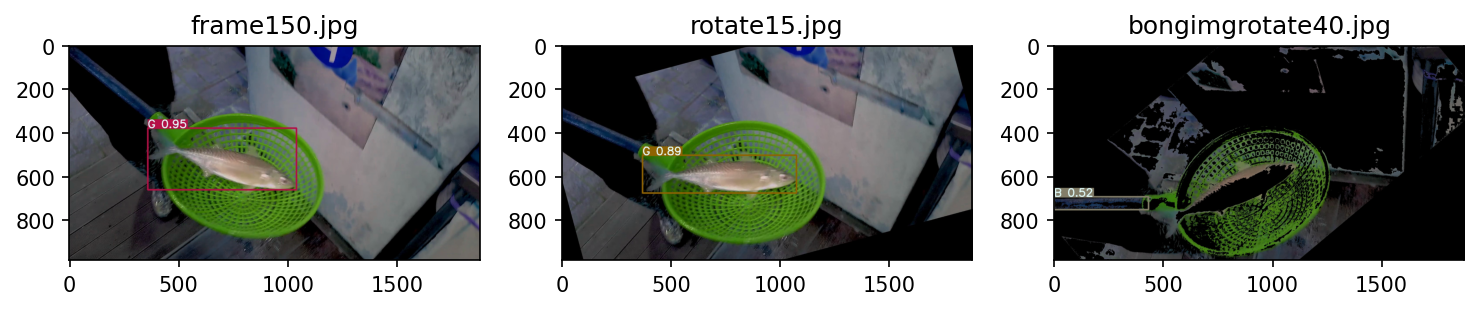

In [29]:
print("Best frame:",bestframe,"Rotated best frame:",rotatedbestframe[0],"Bong best frame:",bongbestframe)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12,8), dpi= 150)
titles = [bestframe, rotatedbestframe[0], bongbestframe]

imgs = [cv2.imread('./runs/detect/exp/'+bestframe),\
        cv2.imread('./runs/detect/exp2/'+rotatedbestframe[0]),\
        cv2.imread('./runs/detect/exp3/'+bongbestframe)]

for i in range(3):
  ax = fig.add_subplot(1, 3, i+1)
  ax.imshow(imgs[i])
  ax.set_title(titles[i])
plt.show()